### Primer enfoque

In [17]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Rutas al dataset
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'  #Dataset VinDR-Mammo
csv_ss1 = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/ss1.csv' #Ruta al csv con las imagenes a recortar
output_training = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training' #ruta donde se creará training
output_test = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test' #ruta donde se creará test 

# Leer las anotaciones CSV que contienen las coordenadas de la ROI
ss1 = pd.read_csv(csv_ss1)

# Crear directorios de salida para training y test
os.makedirs(output_training, exist_ok=True)
os.makedirs(output_test, exist_ok=True)

# Tamaño al que queremos redimensionar los recortes
TARGET_SIZE = (299, 299)

# Función para obtener la ruta del archivo DICOM usando image_id, buscando en los subdirectorios de dicom_root
def get_dicom_path(image_id):
    for study_id in os.listdir(dicom_root):
        study_path = os.path.join(dicom_root, study_id)
        if os.path.isdir(study_path):
            dicom_path = os.path.join(study_path, image_id + '.dicom')
            if os.path.exists(dicom_path):
                return dicom_path
    raise FileNotFoundError(f"No se encontró el archivo DICOM para image_id: {image_id}")

# Función para aplicar windowing y obtener imágenes recortadas (ROI) y redimensionarlas a 299x299 píxeles
def extract_roi(image_name, split):
    # Obtener el image_id (que es la parte antes del guión bajo "_")
    image_id = image_name.split('_')[0]
    dicom_path = get_dicom_path(image_id)

    # Leer la imagen DICOM
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array

    # Verificar si la imagen está vacía o no es válida
    if img is None or img.size == 0:
        print(f"Error: La imagen {image_id} está vacía o no es válida.")
        return

    # Aplicar VOI LUT para ajustar la imagen según los metadatos del DICOM
    img_windowed = apply_voi_lut(img, dicom)

    # Normalizar la imagen para que esté en el rango [0, 255]
    img_windowed = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
    img_windowed = img_windowed.astype(np.uint8)

    # Extraer las coordenadas de la ROI desde el CSV utilizando el image_name
    try:
        x1, y1 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmin'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymin'].values[0]))
        x2, y2 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmax'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymax'].values[0]))
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return

    # Verificar si las coordenadas están dentro del rango de la imagen
    # Esto es porque hay imagenes con coordenadas negativas y tiraba error (eran como 5) , lo que hace ahora es que las ajusta a 0
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)

    if not (x1 < x2 and y1 < y2):
        print(f"Error: Coordenadas fuera de los límites para la imagen {image_name}.")
        return

    # Recortar la imagen utilizando las coordenadas de la ROI
    crop = img_windowed[y1:y2, x1:x2]

    # Verificar si el recorte no está vacío
    if crop.size == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío.")
        return

    # Redimensionar el recorte a 299x299 píxeles
    try:
        crop_resized = cv2.resize(crop, TARGET_SIZE)
    except cv2.error as e:
        print(f"Error al redimensionar el recorte para la imagen {image_name}: {e}")
        return

    # Guardar el ROI redimensionado en la carpeta correspondiente a 'train' o 'test'
    if split == 'training':
        output_dir = output_training
    else:
        output_dir = output_test

    # Guardar el recorte con el nombre `image_name.png` directamente en test o training
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    cv2.imwrite(output_path, crop_resized)

    print(f"Imagen ROI guardada en: {output_path}")

# Función para recorrer todas las imágenes del CSV y guardar las ROI redimensionadas
def process_all_images():
    for _, row in ss1.iterrows():
        image_name = row['image_name']
        split = row['split']  # la columna 'split' tiene los valores 'train' o 'test'
        extract_roi(image_name, split)

# Ejecutar el procesamiento de todas las imágenes
process_all_images()


Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training/4e3a578fe535ea4f5258d3f7f4419db8_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training/dac39351b0f3a8c670b7f8dc88029364_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test/2f944efb1cb9579442df2d7fe6a579b7_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test/7385e8cf7b29764525c81de4aa1aebe4_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training/5a94dd668eaa9865b907450c37db6ecc_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training/2bbe58aab434b2a6af7e873ca9adc56d_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing

In [18]:
#Contamos si se guardaron los 1007 recortes

# Rutas a las carpetas de 'test' y 'training'
test_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test'
train_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training'

# Función para contar archivos PNG en un directorio
def contar_png(carpeta):
    return len([archivo for archivo in os.listdir(carpeta) if archivo.endswith('.png')])

# Contar imágenes en 'test' y 'training'
num_test = contar_png(test_dir)
num_train = contar_png(train_dir)

# Mostrar resultados
print(f"Número de imágenes PNG en 'test': {num_test}")
print(f"Número de imágenes PNG en 'training': {num_train}")


Número de imágenes PNG en 'test': 192
Número de imágenes PNG en 'training': 815


### Segundo Enfoque


### Método basado en el github "ConvNets for Detection of Abnormalities in Mammograms" 

#### Puntos clave de este método:

- Método de Extracción Basado en el Centro de la ROI: En lugar de recortar directamente la ROI basada en las coordenadas xmin, ymin, xmax, ymax, este enfoque utiliza el centro de la ROI y añade un padding dinámico dependiendo del tamaño de la ROI. Esto permite extraer recortes más centrados, sin depender únicamente de los límites estrictos de la ROI original.
Padding Dinámico:

- Se aplica un padding del 20% si la ROI es más pequeña que el tamaño mínimo (598x598) y un padding del 5% si es mayor. Esto asegura que el área alrededor de la anomalía se incluya adecuadamente, independientemente de su tamaño, y ayuda a preservar el contexto anatómico.
Uso de un Tamaño Mínimo de Recorte:

- Se introduce el concepto de MIN_SIZE (598x598) para asegurarse de que el área de interés no se reduzca demasiado antes de hacer el recorte. Esto evita que las anomalías pequeñas se pierdan en el recorte y proporciona un área más amplia de contexto anatómico.
Reducción de Artefactos en Recortes Pequeños:

- Al no forzar el recorte directamente a las coordenadas exactas de la ROI, y en lugar de eso añadir padding basado en el tamaño de la ROI, este enfoque reduce el riesgo de introducir artefactos en imágenes pequeñas, lo que mejora la robustez del modelo cuando se trabaja con imágenes en bruto.


In [15]:
#Enfoque basado en el github

import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Rutas al dataset
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'
csv_ss1 = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/ss1.csv'
output_training2 = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2'
output_test2 = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test2'

# Leer las anotaciones CSV que contienen las coordenadas de la ROI
ss1 = pd.read_csv(csv_ss1)

# Crear directorios de salida para training y test
os.makedirs(output_training2, exist_ok=True)
os.makedirs(output_test2, exist_ok=True)

# Tamaño objetivo al que queremos llegar para el recorte (similar a 299x299)
TARGET_SIZE = (299, 299)
MIN_SIZE = 598  #  el tamaño objetivo para la imagen sin padding.

# Función para obtener la ruta del archivo DICOM usando image_id
def get_dicom_path(image_id):
    for study_id in os.listdir(dicom_root):
        study_path = os.path.join(dicom_root, study_id)
        if os.path.isdir(study_path):
            dicom_path = os.path.join(study_path, image_id + '.dicom')
            if os.path.exists(dicom_path):
                return dicom_path
    raise FileNotFoundError(f"No se encontró el archivo DICOM para image_id: {image_id}")

# Función para aplicar el recorte basado en el centro de la ROI, con padding variable.
def extract_roi(image_name, split):
    # Obtener el image_id (parte antes del guión bajo "_")
    image_id = image_name.split('_')[0]
    dicom_path = get_dicom_path(image_id)

    # Leer la imagen DICOM
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array

    # Aplicar VOI LUT para ajustar la imagen según los metadatos del DICOM
    img_windowed = apply_voi_lut(img, dicom)

    # Normalizar la imagen para que esté en el rango [0, 255]
    #Normalizar al rango [0, 255] asegura que todas las imágenes se encuentren en un rango de intensidades estándar para su procesamiento, guardado en formatos comunes y visualización adecuada.
    img_windowed = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
    img_windowed = img_windowed.astype(np.uint8)

    # Extraer las coordenadas de la ROI desde el CSV utilizando el image_name
    try:
        x1, y1 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmin'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymin'].values[0]))
        x2, y2 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmax'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymax'].values[0]))
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return

    # Verificar que las coordenadas sean válidas
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)
    
    # Calcular el centro de la ROI
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Determinar el tamaño de la ROI original
    width = x2 - x1
    height = y2 - y1

    # Agregar padding variable según el tamaño de la ROI
    if width < MIN_SIZE or height < MIN_SIZE:
        # ROI es más pequeña que el tamaño objetivo, añadimos padding (20%)
        padding_x = int(width * 0.2)
        padding_y = int(height * 0.2)
    else:
        # ROI es mayor, añadimos menos padding (5%)
        padding_x = int(width * 0.05)
        padding_y = int(height * 0.05)

    # Establecer los nuevos límites de la imagen recortada, con padding
    x1_new = max(center_x - (MIN_SIZE // 2) - padding_x, 0)
    y1_new = max(center_y - (MIN_SIZE // 2) - padding_y, 0)
    x2_new = min(center_x + (MIN_SIZE // 2) + padding_x, img_windowed.shape[1])
    y2_new = min(center_y + (MIN_SIZE // 2) + padding_y, img_windowed.shape[0])

    # Verificar que las nuevas coordenadas sean válidas
    if not (x1_new < x2_new and y1_new < y2_new):
        print(f"Error: Coordenadas fuera de los límites para la imagen {image_name}.")
        return

    # Recortar la imagen utilizando las nuevas coordenadas ajustadas
    crop = img_windowed[y1_new:y2_new, x1_new:x2_new]

    # Verificar si el recorte no está vacío
    if crop.size == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío.")
        return

    # Redimensionar el recorte a 299x299 píxeles
    try:
        crop_resized = cv2.resize(crop, TARGET_SIZE)
    except cv2.error as e:
        print(f"Error al redimensionar el recorte para la imagen {image_name}: {e}")
        return

    # Guardar el ROI redimensionado en la carpeta correspondiente a 'train' o 'test'
    if split == 'training':
        output_dir = output_training2
    else:
        output_dir = output_test2

    # Guardar el recorte con el nombre `image_name.png` directamente en train o test
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    cv2.imwrite(output_path, crop_resized)

    print(f"Imagen ROI guardada en: {output_path}")

# Función para recorrer todas las imágenes del CSV y guardar las ROI redimensionadas
def process_all_images():
    for _, row in ss1.iterrows():
        image_name = row['image_name']
        split = row['split']  # la columna 'split' tiene los valores 'train' o 'test'
        extract_roi(image_name, split)

# Ejecutar el procesamiento de todas las imágenes
process_all_images()


Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2/4e3a578fe535ea4f5258d3f7f4419db8_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2/dac39351b0f3a8c670b7f8dc88029364_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test2/2f944efb1cb9579442df2d7fe6a579b7_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test2/7385e8cf7b29764525c81de4aa1aebe4_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2/5a94dd668eaa9865b907450c37db6ecc_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2/2bbe58aab434b2a6af7e873ca9adc56d_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preproc

In [16]:
#Contamos si se guardaron los 1007 recortes

# Rutas a las carpetas de 'test' y 'training'
test_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/test2'
train_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2'

# Función para contar archivos PNG en un directorio
def contar_png(carpeta):
    return len([archivo for archivo in os.listdir(carpeta) if archivo.endswith('.png')])

# Contar imágenes en 'test' y 'training'
num_test = contar_png(test_dir)
num_train = contar_png(train_dir)

# Mostrar resultados
print(f"Número de imágenes PNG en 'test': {num_test}")
print(f"Número de imágenes PNG en 'training': {num_train}")


Número de imágenes PNG en 'test': 192
Número de imágenes PNG en 'training': 815


Comparando la imagen: 032ab9e0ecd5fd673517ffa3eb805d15_0.png


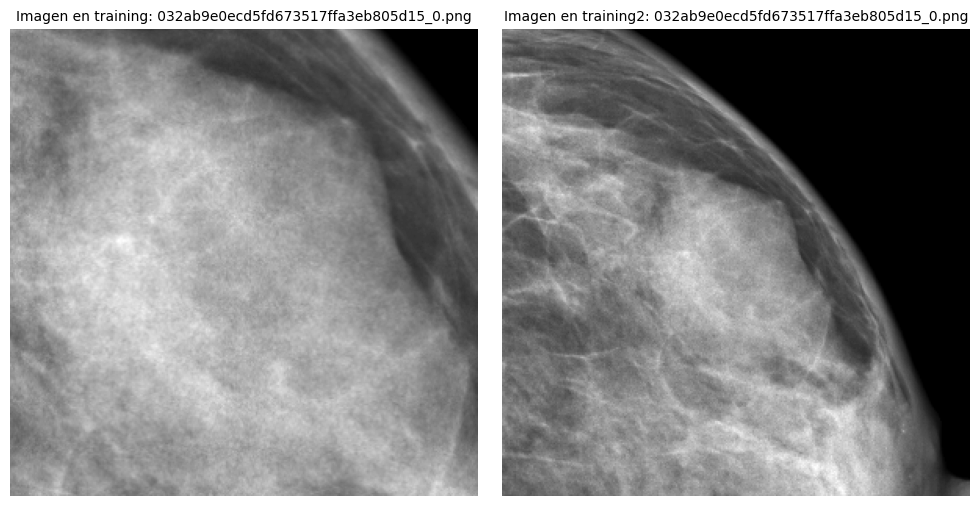

In [34]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Rutas a las carpetas de 'training' y 'training2'
training_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training'
training2_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/training2'

# Función para seleccionar una imagen al azar con el mismo nombre en ambas carpetas
def get_random_image_name(training_dir, training2_dir):
    # Obtener lista de imágenes en cada carpeta
    training_images = set(os.listdir(training_dir))
    training2_images = set(os.listdir(training2_dir))
    
    # Encontrar los nombres de las imágenes comunes en ambas carpetas
    common_images = list(training_images.intersection(training2_images))
    
    if not common_images:
        raise ValueError("No se encontraron imágenes comunes en ambas carpetas.")
    
    # Seleccionar una imagen al azar de las comunes
    random_image = random.choice(common_images)
    return random_image

# Función para cargar y devolver las dos imágenes de ambas carpetas
def load_images(image_name):
    img1_path = os.path.join(training_dir, image_name)
    img2_path = os.path.join(training2_dir, image_name)
    
    # Cargar las imágenes
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    
    return img1, img2

# Función para visualizar las dos imágenes lado a lado
def plot_images(img1, img2, image_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Mostrar la imagen 1 (training)
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(f"Imagen en training: {image_name}", fontsize=10)  # Ajustar el tamaño del texto
    axes[0].axis('off')
    
    # Mostrar la imagen 2 (training2)
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(f"Imagen en training2: {image_name}", fontsize=10)  # Ajustar el tamaño del texto
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Función principal
def compare_random_images():
    # Obtener una imagen al azar que esté en ambas carpetas
    random_image_name = get_random_image_name(training_dir, training2_dir)
    print(f"Comparando la imagen: {random_image_name}")
    
    # Cargar las imágenes
    img1, img2 = load_images(random_image_name)
    
    # Comprobar si las imágenes se cargaron correctamente
    if img1 is None or img2 is None:
        print(f"Error al cargar la imagen {random_image_name}.")
        return
    
    # Ploteamos las imágenes lado a lado para compararlas
    plot_images(img1, img2, random_image_name)

# Ejecutar la comparación
compare_random_images()


#### Conclusiones:

Centro de la ROI: El segundo enfoque extrae la región de interés (ROI) centrada en el área relevante. Esto asegura que el área importante esté bien posicionada dentro del recorte y se mantenga la mayor cantidad posible de contexto anatómico circundante. El primer enfoque, al redimensionar directamente según el tamaño de la ROI, puede cortar partes importantes o incluir zonas menos relevantes, lo que afecta la claridad.

Padding Dinámico: En el segundo enfoque, se añade un padding variable dependiendo del tamaño de la ROI. Si la ROI es pequeña, se añade más padding para capturar más contexto, mientras que si la ROI es grande, se añade menos padding. Esto permite que tanto ROIs grandes como pequeñas se ajusten mejor en el recorte final, mientras que en el primer enfoque, el redimensionamiento rígido a un tamaño fijo introduce distorsiones.

Conservación del Contexto Anatómico: El segundo enfoque, al no forzar la ROI a un tamaño fijo antes del redimensionamiento, preserva mejor los detalles anatómicos circundantes que pueden ser clave para una correcta interpretación médica. Esto se traduce en imágenes visualmente más coherentes y con mejor calidad.

Eliminación de Artefactos por Redimensionamiento: El primer enfoque introduce artefactos o pérdida de resolución debido al redimensionamiento directo de la ROI a un tamaño específico (299x299). En cambio, el segundo enfoque, al utilizar el padding antes de recortar y redimensionar, evita esa pérdida de calidad, lo que resulta en una imagen final más nítida y detallada.